## Delivery Duration Prediction

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from:

__Start:__ the time consumer submits the order `(created_at)` to

__End:__ when the order will be delivered to the consumer `(actual_delivery_time)`

#### My Approach

The dataset comes with two other predicted values: `estimated_order_place_duration` and `estimated_store_to_consumer_driving_duration`. The missing piece is the amount of time the order spends in the store. In addition to generic feature engineering, I will be creating separate order 'prep_time' statistics tables/dataframes to simulate gold fact tables in a database or features from a feature store (i.e. Feather, Feast) that would in turn live in a data lake.

This is a fairly popular exercise so it is possible to derive performance objectives. My goal is to produce a feature set and model that has a test RMSE of less than 900 seconds against a holdout size of 0.2, a cross-validated RMSE of less than 950 and a test MAE of less than 600 seconds. My stretch goal is a cross-validated RMSE less than 900. For reference, the best models publically available produce a test RMSE around 980 - 1000 seconds with a holdout size of 0.2. 

In [2]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

import pickle
import pandas as pd
import pyarrow as pa
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime as dt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score,roc_auc_score,log_loss
from scipy import stats

from flaml import AutoML
from flaml.automl.model import XGBoostEstimator

In [5]:
np.random.seed(42)

In [6]:
## NOTE that all feature engineering functions can be found in doordash_feature_eng.py
train_df = pd.read_csv('train_df.csv')
train_df = train_df.drop(columns=['Unnamed: 0','latest_update'])

In [6]:
def createBaseline(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
    assert 'actual_total_delivery_duration' in historical_data.columns; 'Column actual_total_delivery_duration is not in the given DataFrame. Ensure that addFeatures_durations() was run on the provided DataFrame.'
    try:
        baseline_data = historical_data[['store_id','actual_total_delivery_duration']]
        baseline_data = baseline_data.dropna()
        baseline_data = pd.merge(
            left=baseline_data,
            right=baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean,np.std]),
            how='inner',
            on='store_id'
        )
        baseline_data['z-score'] = (baseline_data['actual_total_delivery_duration'] - baseline_data['mean']) / baseline_data['std']
        baseline_data = baseline_data.loc[(baseline_data['z-score'] <=3) & (baseline_data['z-score'] >= -3)]
        baseline_avgs = baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean])
        baseline_data = pd.merge(
            left=historical_data[['store_id','actual_total_delivery_duration']].dropna(),
            right=baseline_avgs,
            on='store_id'
        )
        baseline_MAE = mean_absolute_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'])
        baseline_RMSE = mean_squared_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'],squared=False)
    except Exception as ex:
        raise ex
    return {'baseline_MAE:':baseline_MAE,'baseline_RMSE:':baseline_RMSE}

array([[<AxesSubplot:title={'center':'actual_total_delivery_duration'}>]],
      dtype=object)

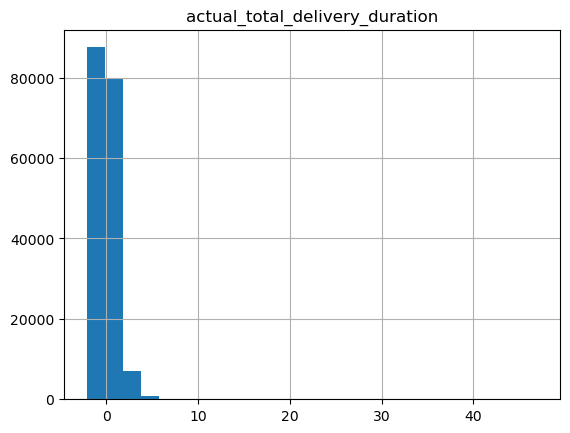

In [27]:
## What is the distribution of the actual_total_delivery_time values around the mean?
x = train_df[['actual_total_delivery_duration']].apply(stats.zscore)
x.hist(column='actual_total_delivery_duration',bins=25)

In [181]:
## dimensionality reduction functions with variance inflaction

def calcVIF(feature_frame:pd.DataFrame,target_feature:str):
    try:
        feature_frame = add_constant(feature_frame)
        feature_list = feature_frame.drop(columns=[target_feature]).columns.to_list()
        vif_frame = pd.DataFrame()
        vif_frame['feature'] = feature_list
        vif_frame['VIF'] = [variance_inflation_factor(feature_frame[feature_list].values,i) for i in range(len(feature_list))]
    except Exception as ex:
        raise ex
    return vif_frame.sort_values(by=['VIF'],ascending=False).reset_index(drop=True)

def VIF_dim_reduction(feature_frame:pd.DataFrame,target_feature:str,vif_limit:int):
    vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
    try:
        ## drop nan columns from feature set, nan VIF values from base VIF table
        vif_table['VIF'].replace(to_replace=[np.inf,-np.inf],value=np.nan,inplace=True)
        nan_list = vif_table[vif_table['VIF'].isnull()]['feature'].to_list()
        feature_frame = feature_frame.drop(columns=nan_list)
        vif_table = vif_table.set_index(vif_table.feature)
        vif_table = vif_table.drop(labels=nan_list).reset_index(drop=True)
        ## start
        multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
        while multicollinearity:
            lead_vif_feature = vif_table['feature'].values.tolist()[1]
            feature_frame = feature_frame.drop(columns=lead_vif_feature)
            vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
            multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
    except Exception as ex:
        raise ex
    return feature_frame,vif_table

In [4]:
## feature selection/dimensionality reduction with PCA
##TODO #2 make a class for PCA
##TODO #3 retain row numbers in scaler --DONE

def build_train_test(dataset:pd.DataFrame,target_feature:str,test_size:int):
    try:
        X = dataset.drop(columns=target_feature)
        y = dataset[target_feature]
        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=42)
        x_train,x_test = pd.DataFrame(x_train),pd.DataFrame(x_test)
    except Exception as ex:
        raise ex
    return x_train,x_test,y_train,y_test

def apply_standard_scaler(dataset):
#applies the standard scaler to a single dataset
    scaler = StandardScaler()
    try:
        if type(dataset) == pd.DataFrame:
            scaler = scaler.fit(dataset.values)
            dataset_scaled = scaler.transform(dataset.values)
            dataset_scaled = pd.DataFrame(dataset_scaled,index=dataset.index,columns=dataset.columns)
        else:
            scaler = scaler.fit(dataset)
            dataset_scaled = scaler.transform(dataset)
            test_stdScale = scaler.transform(dataset)
    except Exception as ex:
        raise ex
    return dataset_scaled,scaler

def transform_rmse_to_seconds(scaler,y_test,y_hat_scaled):
    try:
        y_hat_descaled = scaler.inverse_transform(y_hat_scaled.reshape(-1,1))
        rmse_descaled = mean_squared_error(y_pred=y_test,y_true=y_hat_descaled[:,0],squared=False)
    except Exception as ex:
        raise ex
    return y_hat_descaled,rmse_descaled

In [26]:
def PCAcalc_expl_var(x_train,target_expl_variance:int):
## returns the number of components required to explain the target_expl_variance
# and a feature to component ratio to support automation of further dimensionality reduction
    pca = PCA()
    x_train_scaled = apply_standard_scaler(x_train)[0]
    try:
        pca = pca.fit(x_train_scaled)
        components = np.cumsum(pca.explained_variance_ratio_)
        components = [i for i in components if i <= target_expl_variance]
        feature_to_component_ratio = len(components)/x_train.shape[1]
    except Exception as ex:
        raise ex
    return components,feature_to_component_ratio

def PCAcalc_dim_reduction(x_train,x_test,desired_components:int):
## you know, dimensionality reduction
    pca = PCA(n_components=desired_components)
    x_train_scaled,x_test_scaled = apply_standard_scaler(x_train)[0],apply_standard_scaler(x_test)[0]
    try:
        pca = pca.fit(x_train_scaled)
        x_train_pca,x_test_pca = pca.transform(x_train_scaled),pca.transform(x_test_scaled)
    except Exception as ex:
        raise ex
    return x_train_pca,x_test_pca

In [29]:
x_train,x_holdout,y_train,y_holdout = build_train_test(dataset=train_df,target_feature='actual_total_delivery_duration',test_size=0.2)

#### Dimensionality reduction with VIF

In [ ]:
VIF_features = VIF_dim_reduction(feature_frame=train_df,target_feature='actual_total_delivery_duration',vif_limit=20)[1]
VIF_featureset = VIF_features.drop(VIF_features[VIF_features.feature == 'const'].index)
VIF_featureset = VIF_featureset['feature'].to_list()
VIF_featureset = VIF_featureset + ['actual_total_delivery_duration']
VIF_train_df = train_df[VIF_featureset]

In [183]:
x_train_vif,x_test_vif = x_train[VIF_featureset],x_holdout[VIF_featureset]

We need 97 features (out of 166 available) to explain 90 percent of the variance.


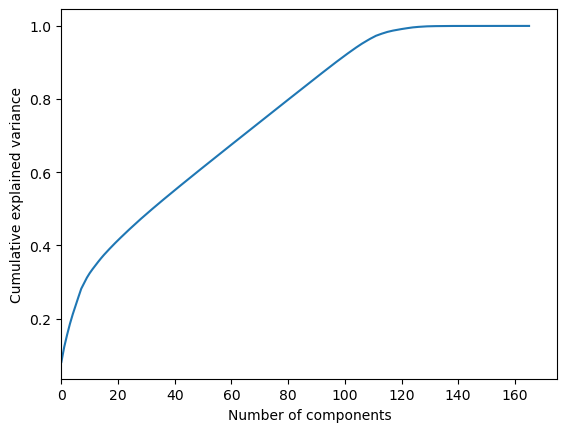

In [33]:
## how many features are needed to explain 90% of the variance?
print("We need " + str(len(PCAcalc_expl_var(x_train=x_train,target_expl_variance=0.9)[0])) + " features (out of " + str(x_train.shape[1]) + " available) to explain 90 percent of the variance.")

x_train_scaled = apply_standard_scaler(x_train)[0]
pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,175,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

#### Dimensionality reduction with PCA

In [46]:
x_train_pca,x_test_pca = PCAcalc_dim_reduction(x_train=x_train,x_test=x_holdout,desired_components=len(PCAcalc_expl_var(x_train=x_train,target_expl_variance=0.9)[0]))

### Model functions, model selection and first round results

In [8]:
def ApplyMethod_autoML(x_train,x_test,y_train,y_test,time_budget=int,metric=str,estimator_list=list,task=str,run_cv=bool,cv_folds=int,file_path=str,model_name=str):
    auto_ml = AutoML()
    kf = KFold(n_splits=cv_folds,random_state=42,shuffle=True)
    cv_scores = []
## recall that the actual_total_delivery_time data is gamma distributed
    class xgbGamma(XGBoostEstimator):
        def __init__(self, task="regression", **config):
            super().__init__(objective='reg:gamma', **config)
    auto_ml.add_learner(learner_name="xgb_gamma",learner_class=xgbGamma)
    try:
        auto_ml.fit(X_train=x_train,y_train=y_train,time_budget=time_budget,metric=metric,estimator_list=estimator_list,task=task,seed=42,verbose=0)
        trained_model = auto_ml
        ## store the model
        model_pickle = open(f'{file_path}/automl_{model_name}.pkl','wb')
        pickle.dump(auto_ml.model,model_pickle,pickle.HIGHEST_PROTOCOL)
        model_pickle.close()
        ## feature importances
        feature_importances_df = pd.DataFrame({'features':auto_ml.feature_names_in_,'importance':auto_ml.feature_importances_})
        ## cross-validation
        if run_cv == True:
            model_count = 1
            for train_index,test_index in kf.split(x_train):
                cv_xtrain,cv_xtest = x_train.iloc[train_index],x_train.iloc[test_index]
                cv_ytrain,cv_ytest = y_train.iloc[train_index],y_train.iloc[test_index]
                auto_ml.fit(X_train=cv_xtrain,y_train=cv_ytrain,time_budget=time_budget,metric=metric,estimator_list=[str(trained_model.best_estimator)],task=task,seed=42,verbose=0)
                ## predict, validate
                cv_yhat = auto_ml.predict(cv_xtest)
                if task == 'regression':
                    rmse = mean_squared_error(y_true=cv_ytest,y_pred=cv_yhat,squared=False)
                    cv_scores.append(rmse)
                if task == 'classification':
                    accuracy = accuracy_score(y_true=cv_ytest,y_pred=cv_yhat)
                    cv_scores.append(accuracy)
        if task == 'regression':
        ## test error
            y_hat_test = auto_ml.predict(x_test)
            test_RMSE = mean_squared_error(y_true=y_test,y_pred=y_hat_test,squared=False)
            test_MAE = mean_absolute_error(y_true=y_test,y_pred=y_hat_test)
            ## feature importances
            ## train error
            y_hat_train = auto_ml.predict(x_train)
            train_RMSE = mean_squared_error(y_true=y_train,y_pred=y_hat_train,squared=False)
            train_MAE = mean_absolute_error(y_true=y_train,y_pred=y_hat_train)
            eval_stats = {
                'train_RMSE:':train_RMSE,
                # gives context to the RMSE; the lower the ratio the better
                'train_RMSE_to_std_ratio':train_RMSE / (np.std(y_train)),
                'train_MAE:':train_MAE,
                'test_RMSE:':test_RMSE,
                # gives context to the RMSE; the lower the ratio the better
                'test_RMSE_to_std_ratio':test_RMSE / (np.std(y_test)),
                'test_MAE:':test_MAE
            }
        if task == 'classification':
            y_hat_test = auto_ml.predict(x_test)
            y_hat_test_proba = auto_ml.predict_proba(x_test)
            y_hat_train = auto_ml.predict(x_train)
            y_hat_train_proba = auto_ml.predict_proba(x_train)
            eval_stats = {
                'train_accuracy': accuracy_score(y_true=y_train,y_pred=y_hat_train),
                'train_roc_auc': roc_auc_score(y_true=y_train,y_score=y_hat_train_proba[:,1]),
                'test_accuracy': accuracy_score(y_true=y_test,y_pred=y_hat_test),
                'test_roc_auc': roc_auc_score(y_true=y_test,y_score=y_hat_test_proba[:,1])
            }
    except Exception as ex:
        raise ex
    return trained_model,feature_importances_df.sort_values(by='importance',ascending=False),eval_stats,cv_scores

#### PCA versus VIF dimensionality reduction:

TODO: #10 rewrite dimensionality reduction write-up

PCA:

    {'train_RMSE:': 922.044768243236,
    'train_RMSE_to_std_ratio': 0.7988714697866253,
    'train_MAE:': 612.6975717392198,
    'test_RMSE:': 1194.7149190518521,
    'test_RMSE_to_std_ratio': 1.0702272444393133,
    'test_MAE:': 905.0272597795322}

Top features (calculated top features, then re-fit the model using the number of features required to explain 90% of the variance (97 out of 166 features)):

    {'train_RMSE:': 755.9607139874619,
    'train_RMSE_to_std_ratio': 0.6549741048200352,
    'train_MAE:': 534.3812971371257,
    'test_RMSE:': 845.7946618754502,
    'test_RMSE_to_std_ratio': 0.7576640049484116,
    'test_MAE:': 565.5202886412139}

No dimensionality reduction:

    {'train_RMSE:': 721.3968731672105,
    'train_RMSE_to_std_ratio': 0.6250275477020395,
    'train_MAE:': 513.6525913271923,
    'test_RMSE:': 833.177098601647,
    'test_RMSE_to_std_ratio': 0.746361174659176,
    'test_MAE:': 557.4898258667698}


The score for the PCA-reduced model is so comparitively poor that it is worthy of suspiscion - I am probably using PCA incorrectly. Given that the goal of dimensionality reduction is to reduce compute requirements (and therefore cost) while retaining as much of the unreduced model's performance as possible, the best choice at the moment is to use a 'top-feature' approach.

In [47]:
pca_regressions = ApplyMethod_autoML(
    x_train=x_train_pca,
    x_test=x_test_pca,
    y_train=y_train,
    y_test=y_holdout,
    time_budget=400,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5,
    file_path='singleModel_noSplit_pickles',
    model_name='xgbregression_pca'
    )
pca_regressions[2]

{'train_RMSE:': 922.044768243236,
 'train_RMSE_to_std_ratio': 0.7988714697866253,
 'train_MAE:': 612.6975717392198,
 'test_RMSE:': 1194.7149190518521,
 'test_RMSE_to_std_ratio': 1.0702272444393133,
 'test_MAE:': 905.0272597795322}

In [75]:
auto_xgb_no_reduction = ApplyMethod_autoML(
    x_train=x_train,
    x_test=x_holdout,
    y_train=y_train,
    y_test=y_holdout,
    time_budget=400,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=True,
    cv_folds=5,
    file_path='singleModel_noSplit_pickles',
    model_name='xgbreg_all_features'
)
auto_xgb_no_reduction[2]

{'train_RMSE:': 775.2071297497488,
 'train_RMSE_to_std_ratio': 0.6716494474690015,
 'train_MAE:': 533.3797480868415,
 'test_RMSE:': 838.6686685160196,
 'test_RMSE_to_std_ratio': 0.7512805304346684,
 'test_MAE:': 559.3233676640386}

In [78]:
np.mean(y_train)

2850.000644965194

In [79]:
np.mean(y_holdout)

2842.231533374848

In [76]:
print("Cross-validation results (RMSE): ")
print(auto_xgb_no_reduction[3])
print("Mean of cross-validation results (RMSE): " + str(np.mean(auto_xgb_no_reduction[3])))
print("Best estimator: " + auto_xgb_no_reduction[0].best_estimator)
print("Best configuration: ")
print(auto_xgb_no_reduction[0].best_config)

Cross-validation results (RMSE): 
[928.0659595118198, 866.9700127007313, 861.5295421654322, 927.3771927147455, 899.9744304738704]
Mean of cross-validation results (RMSE): 896.7834275133198
Best estimator: xgb_limitdepth
Best configuration: 
{'n_estimators': 1028, 'max_depth': 6, 'min_child_weight': 1.4640336660392816, 'learning_rate': 0.02159558962109372, 'subsample': 0.8640052147174596, 'colsample_bylevel': 0.8726369812699186, 'colsample_bytree': 0.9407746256493329, 'reg_alpha': 0.0009765625, 'reg_lambda': 13.44701768864806}


In [36]:
auto_xgb_no_reduction[1].sort_values(by='importance',ascending=False).head(10)

,features,importance
16,onshift_to_outstanding,0.082321
53,store_day_median_total_prep_time,0.054282
21,hour_mean_total_onshift_dashers,0.050517
20,hour_mean_total_outstanding_orders,0.032606
10,est_time_non-prep,0.031837
15,busy_to_outstanding,0.024344
49,store_day_of_week_est_time_prep_per_item_mean,0.023995
22,hour_mean_total_busy_dashers,0.023908
156,created_day_of_week__0,0.020687
31,hour_busy_outs_avg,0.019230


In [42]:
top_features = auto_xgb_no_reduction[1]['features'][:97].to_list()

auto_xgb_top_features = ApplyMethod_autoML(
    x_train=x_train[top_features],
    x_test=x_holdout[top_features],
    y_train=y_train,
    y_test=y_holdout,
    time_budget=400,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5,
    file_path='singleModel_noSplit_pickles',
    model_name='xgbreg_top_thirtyfive_features'
)
auto_xgb_top_features[2]

{'train_RMSE:': 755.9607139874619,
 'train_RMSE_to_std_ratio': 0.6549741048200352,
 'train_MAE:': 534.3812971371257,
 'test_RMSE:': 845.7946618754502,
 'test_RMSE_to_std_ratio': 0.7576640049484116,
 'test_MAE:': 565.5202886412139}

In [136]:
# does the first attempt at modeling improve on a baseline, average-derived model?
createBaseline(historical_data=train_df)

{'baseline_MAE:': 783.5442750429107, 'baseline_RMSE:': 19249.89784985233}

### Results so far

First and foremost, is the work and expense of building and maintaining a model worthwhile when compared to a simple 'baseline' approach that uses averages? The results for that baseline model are as follows:

    {'baseline_MAE:': 783.5442750429107, 'baseline_RMSE:': 19249.89784985233}

I scoured the internet and found two other worked examples that appear to use this dataset:

    Stratascratch: holdout RMSE: 986.6912510458277, holdout_size: 0.2,
    raihanmasud (github): mean 5-fold cv RMSE: 1030.6837, holdout RMSE: 1012, holdout_size: 0.33

Performance statistics for my xgboost model against a holdout sample size of 0.2 are as follows:

    {'train_RMSE:': 775.2071297497488,
    'train_RMSE_to_std_ratio': 0.6716494474690015,
    'train_MAE:': 533.3797480868415,
    'test_RMSE:': 838.6686685160196,
    'test_RMSE_to_std_ratio': 0.7512805304346684,
    'test_MAE:': 559.3233676640386}

Cross-validation results (RMSE): 

    [928.0659595118198, 866.9700127007313, 861.5295421654322, 927.3771927147455, 899.9744304738704]

Mean of cross-validation results (RMSE):

    896.7834275133198

Performance statistics for my xgboost model against a holdout size of 0.33:

    {'train_RMSE:': 873.4991,
    'train_RMSE_to_std_ratio': 0.7611590838185001,
    'train_MAE:': 581.7427,
    'test_RMSE:': 926.9857,
    'test_RMSE_to_std_ratio': 0.7968259664464706,
    'test_MAE:': 605.92535}

Conclusions:
1. The time, effort and expense of building and maintaining a model to predict total delivery time is validated by the comparative performance of the baseline approach.
2. There are two significant differences between my approach to this problem and the two other worked examples I found that I believe explain my superior performance. The first difference is the generic per-store order prep time features (addFeatures_store_prep_stats) and the market+hour aggregation features (addFeatures_relative_abundances). The author of the Stratascratch notebook attempted to predict order prep time and raihanmasud did not bother with prep time at all. Neither user bothered to generate aggregate values based on the most important features for their models. The second difference is my use of autoML to do hyperparameter tuning. Raihanmasud hard-coded hyperparameters for their model and the author of the official Stratascratch notebook did not bother with hyperparameter tuning at all.

<AxesSubplot:xlabel='onshift_to_outstanding', ylabel='actual_total_delivery_duration'>

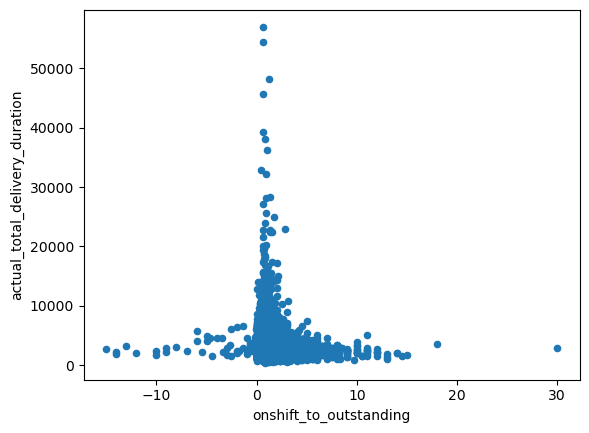

In [154]:
train_df.plot.scatter(x='onshift_to_outstanding',y='actual_total_delivery_duration')

#### What is the relationship between error and acutal_total_delivery_duration?

One could argue that scedasticity does not matter when we make predictions using gradient-boosted-trees - tree-based models are almost invariant to monotonic transformations - but transforms do affect split points. To that end, a test for scedasticity could improve our model if the conditional variance of the data is not constant.

Per the plots below, the variance of the error looks homoscedastic. Trying to actually run White's Lagrange test for heteroscedasticity needs more memory than I can give it.

AxesSubplot(0.125,0.11;0.775x0.77)


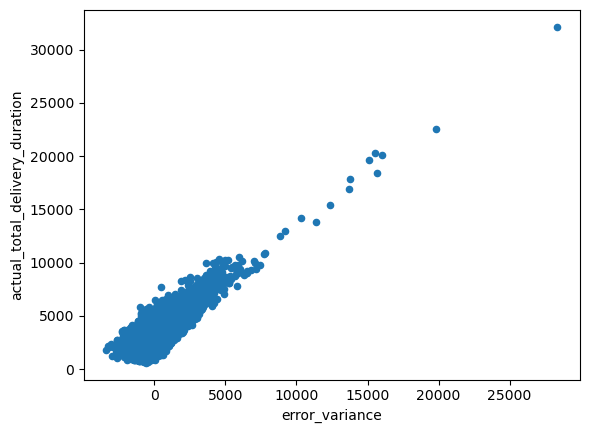

In [84]:
model = auto_xgb_no_reduction[0]
y_hat = model.predict(x_holdout)
error_train_df = x_holdout.copy()
error_train_df['yhat'] = y_hat.reshape(-1,1)
error_train_df = error_train_df.join(train_df[['actual_total_delivery_duration']])
error_train_df['error'] = error_train_df['actual_total_delivery_duration'] - error_train_df['yhat']
error_train_df['error_variance'] = error_train_df['error'] - error_train_df['error'].mean()
print(error_train_df.plot.scatter(x='error_variance',y='actual_total_delivery_duration'))
#error_train_df = error_train_df.drop(columns=['yhat','error','error_variance'])

In [ ]:
## DO NOT RUN THIS CELL unless you are very invested in knowing the scedasticity of the data. It is extremely compute and memory intensive.
# More to the point, scedasticity arguably does not matter for gradient-boosted trees
white_test = het_white(resid=error_train_df['error'].values,exog=x_holdout.values)
white_labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(white_labels,white_test)))

### What about a model that predicts order prep/in-store time?

1. Is the amount of time an order spends in the restaurant (prep time) an important feature? 
2. Would the accuracy of a total delivery time model be improved by having an estimation of order preparation time for each order?
3. Assuming the answers to the first two questions are true, is it worth keeping the store and category prepartion stats 'tables' I made during the feature engineering step?

In [43]:
def append_prep_feature(x_train,x_holdout,y_train,y_holdout):
## returns est_order_total_prep_time from a pre-existing train-test data set
    train,test = x_train.join(y_train),x_holdout.join(y_holdout)
    train['est_order_total_prep_time'] = train['actual_total_delivery_duration'] - train['est_time_non-prep']
    test['est_order_total_prep_time'] = test['actual_total_delivery_duration'] - test['est_time_non-prep']
    y_train_prep,y_holdout_prep = pd.Series(train['est_order_total_prep_time']),pd.Series(test['est_order_total_prep_time'])
    return y_train_prep,y_holdout_prep

In [44]:
## first and foremost, is this model worth building? Is in-store time an important feature?
train,test = x_train.join(y_train),x_holdout.join(y_holdout)
train['est_order_total_prep_time'] = train['actual_total_delivery_duration'] - train['est_time_non-prep']
test['est_order_total_prep_time'] = test['actual_total_delivery_duration'] - test['est_time_non-prep']

hypoth_feature_importances = ApplyMethod_autoML(
    x_train=train,
    x_test=test,
    y_train=y_train,
    y_test=y_holdout,
    time_budget=400,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5,
    file_path='deliveryTime_model_pickles',
    model_name='xgbreg_nosplit'
)
hypoth_feature_importances[2]

{'train_RMSE:': 1.252524806781668,
 'train_RMSE_to_std_ratio': 0.0010852036341405923,
 'train_MAE:': 0.9626938976930332,
 'test_RMSE:': 13.449283092921558,
 'test_RMSE_to_std_ratio': 0.012047886030957794,
 'test_MAE:': 1.542494160620742}

In [45]:
hypoth_feature_importances[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
163,actual_total_delivery_duration,0.790497
164,est_order_total_prep_time,0.202038
20,hour_mean_total_outstanding_orders,0.005233
41,store_est_time_prep_per_item_min,0.001276
10,est_time_non-prep,0.000732
2,num_distinct_items,0.000031
99,clean_store_primary_category__middle-eastern,0.000027
4,max_item_price,0.000021
60,clean_store_primary_category__asian,0.000008
87,clean_store_primary_category__hawaiian,0.000007


Per the performance scores and feature importance table above, providing a delivery time estimation model with an order prep time estimation greatly improves the quality of estimations. Since the feature est_order_total_prep_time is leaky (it depends on the value we are trying to predict), we will need to estimate it instead.

In [49]:
y_train_prep,y_holdout_prep = append_prep_feature(x_train=x_train,x_holdout=x_holdout,y_train=y_train,y_holdout=y_holdout)

In [50]:
prep_est_model = ApplyMethod_autoML(
    x_train=x_train,
    x_test=x_holdout,
    y_train=y_train_prep,
    y_test=y_holdout_prep,
    time_budget=400,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    cv_folds=5,
    run_cv=False,
    file_path='prepTime_model_pickles',
    model_name='xgbreg_nosplit'
)
prep_est_model[2]

{'train_RMSE:': 724.7308358354761,
 'train_RMSE_to_std_ratio': 0.6477738218729179,
 'train_MAE:': 502.5595400840551,
 'test_RMSE:': 831.0113121828417,
 'test_RMSE_to_std_ratio': 0.7684733004461611,
 'test_MAE:': 552.6305024499935}

In [52]:
prep_est_model[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
16,onshift_to_outstanding,0.089348
21,hour_mean_total_onshift_dashers,0.046221
53,store_day_median_total_prep_time,0.034741
49,store_day_of_week_est_time_prep_per_item_mean,0.033508
20,hour_mean_total_outstanding_orders,0.031257
156,created_day_of_week__0,0.018070
134,order_protocol__4.0,0.017247
31,hour_busy_outs_avg,0.016900
15,busy_to_outstanding,0.016766
40,created_day_mean_total_busy_dashers,0.015944


In [53]:
yhat_train,yhat_test = prep_est_model[0].predict(x_train),prep_est_model[0].predict(x_holdout)
composite_train,composite_test = x_train,x_holdout
composite_train['pred_order_prep_time'],composite_test['pred_order_prep_time'] = yhat_train.reshape(-1,1),yhat_test.reshape(-1,1)
#composite_train['composite_deliv_time'],composite_test['composite_deliv_time'] = composite_train['pred_order_prep_time'] + composite_train['est_time_non-prep'],composite_test['pred_order_prep_time'] + composite_test['est_time_non-prep']
# composite_train,composite_test = composite_train.join(y_train),composite_test.join(y_holdout)

In [58]:
composite_deliv_model = ApplyMethod_autoML(
    x_train=composite_train,
    x_test=composite_test,
    y_train=y_train,
    y_test=y_holdout,
    time_budget=400,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    cv_folds=5,
    run_cv=True,
    file_path='deliveryTime_model_pickles',
    model_name='xgbreg_nosplit'
)
composite_deliv_model[2]

{'train_RMSE:': 629.4737460788326,
 'train_RMSE_to_std_ratio': 0.5453841657604123,
 'train_MAE:': 455.779582570263,
 'test_RMSE:': 849.1551127581309,
 'test_RMSE_to_std_ratio': 0.7606743014056613,
 'test_MAE:': 557.112726920179}

In [63]:
print(composite_deliv_model[3])
print(np.mean(composite_deliv_model[3]))

[684.0892768296953, 681.0979618118614, 677.0700958150553, 699.8305918514759, 691.835106692473]
686.7846066001122


In [4]:
print(np.var([684.0892768296953, 681.0979618118614, 677.0700958150553, 699.8305918514759, 691.835106692473]))
print(np.var([928.0659595118198, 866.9700127007313, 861.5295421654322, 927.3771927147455, 899.9744304738704]))

65.93594673475154
811.2867824481718


Holdout, train scores:

    {'train_RMSE:': 629.4737460788326,
    'train_RMSE_to_std_ratio': 0.5453841657604123,
    'train_MAE:': 455.779582570263,
    'test_RMSE:': 849.1551127581309,
    'test_RMSE_to_std_ratio': 0.7606743014056613,
    'test_MAE:': 557.112726920179}

cv RMSE scores: 

    [684.0892768296953, 681.0979618118614, 677.0700958150553, 699.8305918514759, 691.835106692473]

Mean RMSE from cv: 

    686.7846066001122

cv RMSE to y-true std: 

    0.7761858125345661

In [60]:
composite_deliv_model[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
163,pred_order_prep_time,0.225464
10,est_time_non-prep,0.060059
126,market_id__2.0,0.019890
130,market_id__6.0,0.017967
152,created_hour_of_day__20,0.017099
71,clean_store_primary_category__catering,0.014153
9,estimated_store_to_consumer_driving_duration,0.013680
29,hour_onshift_outs_avg,0.012411
16,onshift_to_outstanding,0.010589
136,order_protocol__6.0,0.010142


#### Conclusions on adding an estimated order prep-time feature

For the sake of a holistic comparison, let us compare the two-step ensemble model and the single-step model in three distinct ways:

**Holdout performance:**  Despite being a valuable feature (according to feature importance), estimating order preparation time does not have a discernable impact on the performance of a model compared to a model that was not trained with said feature.

**Cross-validation scores:** The mean of the RMSE scores for the two-step model (686.78) is significantly better than the mean of the RMSE scores for the single model (896.78). What's more, the variance of the two-step ensemble model (65.9359) is dramatically lower/better than the variance seen in the scores for the single model (811.2868).

**Training set performance:** Normally one can ignore the performance of the model's evaluation of a training set but the significant gap between the holdout score and the training score, in addition to the low variance of the cv scores, may point to the two-step ensemble model being overfitted.

Recall that there are many outliers in this dataset, and that RMSE is very sensitive to outliers compared to other performance evaluation metrics like MAE. The results of the comparison above and the uniformity of the cv scores present us with a final question/hypothesis that will let us determine if the prep. time estimation is worth the time and expense:

**Does adding an estimated order preparation time feature improve a model's ability to accurately estimate total delivery time values that will fall within a normal distribution/within three DoF of the mean?**

In other words, even if the two-step ensemble model does not offer improved outlier estimation performance, does the addition of order preparation time improve our ability to estimate total delivery time for 'normal' orders? As evidenced by previous analysis, whatever feature(s) that indicate whether or not the total delivery time will be a positive outlier (greater than the mean) are not available in the featureset. Given the nature of the problem, one could argue that what makes an order an outlier is attributable to too many random factors and is not knowable.

The final part of this notebook will compare the performance of the single-step and two-step ensemble models against data with and without various mixes of total delivery time outliers.

In [12]:
X = train_df.drop(columns=['actual_total_delivery_duration'])
y = train_df[['actual_total_delivery_duration']]